# Classifier using kx,ky

In [2]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *

# Functions to load the time domain data, transform it to the FFT space, PCA space, etc...

In [3]:
def load_data(npoints, folder_path = "D:data OT//"):
    """
    Load the data, added targets2 for making a pool for the stratified 
    cross-validation procedure
    """

    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    target_fix=[]
    particle_group=[]
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data


    for i in range(0,len(path_files_TD)):


        current_path = path_files_TD[i]

        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        
        #max n_segments possible
        n_segments = int(len(current_df[0])/npoints)
        
        xx = np.array(current_df[0])[0:n_segments*npoints]
        yy = np.array(current_df[1])[0:n_segments*npoints]
        sums = np.array(current_df[2])[0:n_segments*npoints]

        #alterei isto que me estava a dar problemas com segmentos de tamanho variável
        x_data.append(np.array([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        y_data.append(np.array([yy[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        sum_data.append(np.array([sums[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        target_fix.append(current_path.split('//')[-1].split('.')[0][:-1])

        print(current_path + " Read "+ str(n_segments) + " segments", end = '\r')

        for i in range(0,int(len(xx)/npoints)):

            target.append(current_path.split('//')[-1].split('.')[0][:-1])
            
            #this will create a new index that corresponds to particle number, to be grouped in the cross-validation strategy
            particle_group.append(current_path.split('//')[-1].split('.')[0][-1:])


    return np.array(target), np.array(x_data), np.array(y_data), np.array(sum_data), np.array(particle_group),target_fix


def preprocess_data_fft(x_data, y_data, sum_data, target):
    
    """
    Computes the fft for each data, labels, dummy_labels and unique_targets list
    """
    data_X= []
    data_Y = []
    data_Sum = []
    #remove the continuum component
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_X.append(np.abs(fft_x))
            data_Y.append(np.abs(fft_y))
            data_Sum.append(np.abs(fft_sum))
            

    data_X=np.array(data_X)
    data_Y=np.array(data_Y)
    data_Sum=np.array(data_Sum)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        
        labels.append(np.where(target[i]==unique_targets)[0][0])
        
        
        #dummy
        index = np.where(target[i]==unique_targets)[0][0]
        arr = np.zeros(len(unique_targets))
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets


        

def pca_data_construct_new_model(data_X, data_Y, data_Sum, ncomp=3 ):
    """
    Train and projects the data in the PCA space, 
    recovers the projection and models
    """
        
    model_X = decomposition.PCA(n_components=ncomp)
    model_X.fit(data_X)
    PCs_X = model_X.transform(data_X)

    model_Y = decomposition.PCA(n_components=ncomp)
    model_Y.fit(data_Y)
    PCs_Y = model_Y.transform(data_Y)

    model_Sum = decomposition.PCA(n_components=ncomp)
    model_Sum.fit(data_Sum)
    PCs_Sum = model_Sum.transform(data_Sum)
    
    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs, [model_X,model_Y,model_Sum]

def pca_data_compute_from_previous_model(data_X, data_Y, data_Sum, models, ncomp=3):
    """
    Projects the data with previously trained pca models
    """
    model_X = models[0]
    model_Y = models[1]
    model_Sum = models[2]
    
    PCs_X = model_X.transform(data_X)

    PCs_Y = model_Y.transform(data_Y)

    PCs_Sum = model_Sum.transform(data_Sum)

    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs


# Load the data

In [4]:

folder = "D:data OT - TT//TotalData//"
npoints   =  20000
target, x_data, y_data, sum_data, particle_group,target_fix = load_data(npoints, folder)


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [5]:
data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets = preprocess_data_fft(x_data, y_data, sum_data, target)

# Equipartition method

In [6]:
#Constants
calibration_factor_x = 1.2523639992636278e-6 #m/V
calibration_factor_y = 1.5930991659754123e-6 #m/V

#boltzmann constant
k_b = 1.38064852*10**(-23) #J K^-1

#absolute temperature = 
T = 295.15 #K

In [7]:
def normalize(xdata,ydata,sumdata):
    """
    Normalize the signals to the sum intensity.
    """
    new_xdata = xdata/sumdata
    new_ydata = ydata/sumdata
    
    return new_xdata, new_ydata

def calibration(xdata,ydata):
    """
    Transforms the intensity data to position data
    """
    new_xdata = xdata * calibration_factor_x
    new_ydata = ydata * calibration_factor_y
    
    return new_xdata, new_ydata

def stiffness(xdata,ydata):
    """
    Computes the stiffness of the trap
    """
    
    kx = k_b*T/np.var(xdata)
    ky = k_b*T/np.var(ydata)
    return kx, ky


In [8]:
particle_label= []
kx_list = []
ky_list = []
for ind in range(0,len(x_data)):
    
    for i in range(0,len(x_data[ind])):
        xdata0 = x_data[ind][i]
        ydata0 = y_data[ind][i]
        sumdata0 = sum_data[ind][i]

        #normalization
        xdata, ydata = normalize(xdata0,ydata0,sumdata0)

        #calibration of the position
        xdata, ydata = calibration(xdata, ydata)

        #stiffness
        kx, ky = stiffness(xdata, ydata)
        kx_list.append(kx)
        ky_list.append(ky)
        #print(target_fix[ind])
        #print("kx = " + str(kx))
        #print("ky = " + str(ky))

        particle_label.append(target_fix[ind])
kx_list = np.array(kx_list)
ky_list = np.array(ky_list)
particle_label = np.array(particle_label)

In [9]:
#Print summary table


In [10]:

label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(particle_label==label0)[0]
i1= np.where(particle_label==label1)[0]
i2= np.where(particle_label==label2)[0]
i3= np.where(particle_label==label3)[0]
i4= np.where(particle_label==label4)[0]
i5= np.where(particle_label==label5)[0]


# Stiffness Plots

<IPython.core.display.Javascript object>


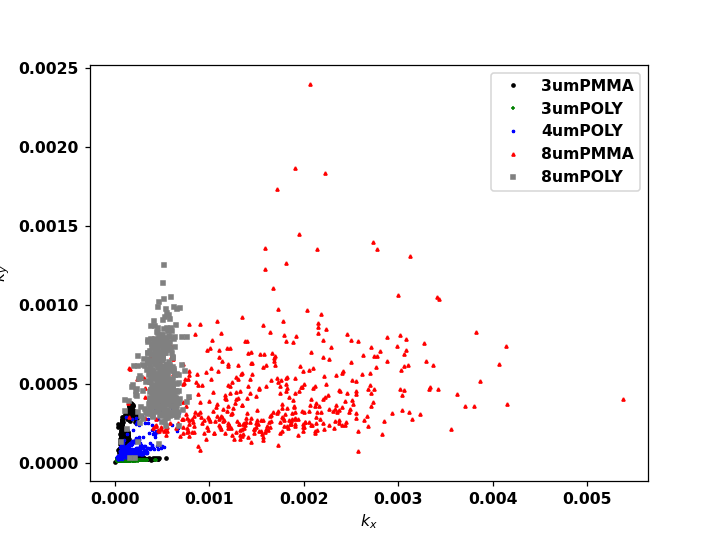

Text(0, 0.5, '$k_y$')

In [16]:
%matplotlib notebook
subplots()
ms=2

s0=0
s1=0
s2=0
s3=0
s4=0
s5=0

plot(kx_list[i0],ky_list[i0],'o',color='k',ms=ms,label=label0)
plot(kx_list[i1],ky_list[i1],'+',color='g',ms=ms,label=label1)
plot(kx_list[i2],ky_list[i2],'*',color='b',ms=ms,label=label2)
plot(kx_list[i3],ky_list[i3],'^',color='r',ms=ms,label=label3)
plot(kx_list[i4],ky_list[i4],'s',color='grey',ms=ms,label=label4)
#plot(kx_list[i5],ky_list[i5],'x',color='y',ms=ms,label=label5)
    
legend()
xlabel("$k_x$")
ylabel("$k_y$")

In [17]:
# Construct Cross Validation
#Construct the 6-fold stratified crossvalidation set

def crossval_set(data_X, data_Y, target, particle_group, i):
    """
    Contructs stratified crossvalidation folds taking a particle with number i out and considering it as test
    """
    
    unique_particle_group = np.unique(particle_group)
    
    print("Particle group " + str(i))
        
    #select the test group and append to the lists
    index = np.where(np.array(particle_group) == unique_particle_group[i])[0]
    
    test_sets_data_X = data_X[index]
    test_sets_data_Y = data_Y[index]

    test_sets_labels = target[index]
    test_particle_group = particle_group[index]
        
    #select the train group and append to the lists
    index = np.where(np.array(particle_group) != unique_particle_group[i])[0]
        
    train_sets_data_X = data_X[index]
    train_sets_data_Y = data_Y[index]

    train_sets_labels = target[index]
    train_particle_group = particle_group[index]

    return train_sets_data_X, train_sets_data_Y,  train_sets_labels, train_particle_group, test_sets_data_X, test_sets_data_Y, test_sets_labels, test_particle_group

In [13]:
def test_a_model(model, train_sets_data_X, train_sets_data_Y,  train_sets_labels, 
                 test_sets_data_X, test_sets_data_Y, test_sets_labels, 
                 unique_targets,
                 confusion_matrix = False):
    
    """
    Test a given model, returning accuracy results and confusion matrix
    """
    features_train = np.stack([train_sets_data_X, train_sets_data_Y],axis=1)
    features_test = np.stack([test_sets_data_X, test_sets_data_Y],axis=1)
    
    scaler = preprocessing.StandardScaler()
    scaler.fit(features_train)
    
    features_train = scaler.transform(features_train)
    features_test = scaler.transform(features_test)
    
    model.fit(features_train ,train_sets_labels)
    score_train = model.score(features_train , train_sets_labels)
    score_test = model.score(features_test, test_sets_labels)

    #Generate a confusion matrix
    labels_pred = model.predict(features_train)
    conf_mat_train = metrics.confusion_matrix(train_sets_labels, labels_pred,normalize="true")
    
    #Generate a confusion matrix
    labels_pred = model.predict(features_test)
    conf_mat_pred = metrics.confusion_matrix(test_sets_labels, labels_pred,normalize="true")
        
    if confusion_matrix:
        metrics.ConfusionMatrixDisplay(conf_mat_train,display_labels=unique_targets).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        
        metrics.ConfusionMatrixDisplay(conf_mat_pred,display_labels=unique_targets).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        

        
        
        
    print("Model Accuracy -> " + str(np.mean(score_test)))
    return score_train, score_test,conf_mat_train,conf_mat_pred


In [21]:
from tqdm import *


model_list_score_train=[]
model_list_score_test=[]
model_list_conf_train=[]
model_list_conf_test=[]

models_to_test=[ensemble.RandomForestClassifier(n_estimators=100,random_state=0), 
                neighbors.KNeighborsClassifier(30),
                svm.SVC(kernel="linear", C=3),
               linear_model.LogisticRegression(),
                neural_network.MLPClassifier(activation = 'tanh')]

pbar = tqdm(total=len(models_to_test)*len(np.unique(particle_group)))

for model in models_to_test:

    list_score_train =[]
    list_score_test = []
    list_conf_train = []
    list_conf_test = []
    print(model)
    
    
    for index in range(0,len(np.unique(particle_group))):
        pbar.update(1)
        
        train_sets_data_X, train_sets_data_Y, train_sets_labels, train_particle_group, test_sets_data_X, test_sets_data_Y, test_sets_labels, test_particle_group = crossval_set(kx_list, ky_list, target, particle_group, index)
        print(np.unique(train_particle_group), end= '\t')
        print(np.unique(test_particle_group))

        score_train, score_test, conf_train, conf_test = test_a_model(model, train_sets_data_X, train_sets_data_Y,  train_sets_labels, 
                 test_sets_data_X, test_sets_data_Y, test_sets_labels, 
                 unique_targets,
                 confusion_matrix = False)

        list_score_train.append(score_train)
        list_score_test.append(score_test)
        list_conf_train.append(conf_train)
        list_conf_test.append(conf_test)
    

    model_list_score_train.append(list_score_train)
    model_list_score_test.append(list_score_test)
    model_list_conf_train.append(np.array(list_conf_train).mean(axis=0))
    model_list_conf_test.append(np.array(list_conf_test).mean(axis=0))
    
    


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

RandomForestClassifier(random_state=0)
Particle group 0
['2' '3' '4' '5' '6']	['1']



  7%|█████▌                                                                             | 2/30 [00:00<00:05,  5.51it/s]

Model Accuracy -> 0.9070796460176991
Particle group 1
['1' '3' '4' '5' '6']	['2']



 10%|████████▎                                                                          | 3/30 [00:00<00:06,  4.15it/s]

Model Accuracy -> 0.6755555555555556
Particle group 2
['1' '2' '4' '5' '6']	['3']



 13%|███████████                                                                        | 4/30 [00:01<00:07,  3.60it/s]

Model Accuracy -> 0.6674057649667405
Particle group 3
['1' '2' '3' '5' '6']	['4']



 17%|█████████████▊                                                                     | 5/30 [00:01<00:07,  3.36it/s]

Model Accuracy -> 0.7831858407079646
Particle group 4
['1' '2' '3' '4' '6']	['5']



 20%|████████████████▌                                                                  | 6/30 [00:01<00:07,  3.16it/s]

Model Accuracy -> 0.8133333333333334
Particle group 5
['1' '2' '3' '4' '5']	['6']



 23%|███████████████████▎                                                               | 7/30 [00:02<00:07,  3.11it/s]

Model Accuracy -> 0.7555555555555555
KNeighborsClassifier(n_neighbors=30)
Particle group 0
['2' '3' '4' '5' '6']	['1']



 27%|██████████████████████▏                                                            | 8/30 [00:02<00:06,  3.53it/s]


Model Accuracy -> 0.8429203539823009
Particle group 1
['1' '3' '4' '5' '6']	['2']
Model Accuracy -> 0.6777777777777778


 30%|████████████████████████▉                                                          | 9/30 [00:02<00:05,  3.88it/s]

Particle group 2
['1' '2' '4' '5' '6']	['3']



 33%|███████████████████████████▎                                                      | 10/30 [00:02<00:04,  4.11it/s]

Model Accuracy -> 0.7028824833702882
Particle group 3
['1' '2' '3' '5' '6']	['4']



 37%|██████████████████████████████                                                    | 11/30 [00:02<00:04,  4.16it/s]

Model Accuracy -> 0.7632743362831859
Particle group 4
['1' '2' '3' '4' '6']	['5']



 40%|████████████████████████████████▊                                                 | 12/30 [00:03<00:04,  4.18it/s]

Model Accuracy -> 0.96
Particle group 5
['1' '2' '3' '4' '5']	['6']



 43%|███████████████████████████████████▌                                              | 13/30 [00:03<00:04,  3.96it/s]

Model Accuracy -> 0.8577777777777778
SVC(C=3, kernel='linear')
Particle group 0
['2' '3' '4' '5' '6']	['1']



 47%|██████████████████████████████████████▎                                           | 14/30 [00:03<00:05,  3.08it/s]

Model Accuracy -> 0.6216814159292036
Particle group 1
['1' '3' '4' '5' '6']	['2']



 50%|█████████████████████████████████████████                                         | 15/30 [00:04<00:05,  2.81it/s]

Model Accuracy -> 0.5711111111111111
Particle group 2
['1' '2' '4' '5' '6']	['3']



 53%|███████████████████████████████████████████▋                                      | 16/30 [00:04<00:05,  2.71it/s]

Model Accuracy -> 0.5033259423503326
Particle group 3
['1' '2' '3' '5' '6']	['4']



 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:05<00:04,  2.61it/s]

Model Accuracy -> 0.6216814159292036
Particle group 4
['1' '2' '3' '4' '6']	['5']



 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:05<00:05,  2.30it/s]

Model Accuracy -> 0.6088888888888889
Particle group 5
['1' '2' '3' '4' '5']	['6']



 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:06<00:02,  3.62it/s]

Model Accuracy -> 0.5755555555555556
LogisticRegression()
Particle group 0
['2' '3' '4' '5' '6']	['1']
Model Accuracy -> 0.672566371681416
Particle group 1
['1' '3' '4' '5' '6']	['2']
Model Accuracy -> 0.6311111111111111
Particle group 2
['1' '2' '4' '5' '6']	['3']



 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:06<00:01,  5.62it/s]

Model Accuracy -> 0.614190687361419
Particle group 3
['1' '2' '3' '5' '6']	['4']
Model Accuracy -> 0.6526548672566371
Particle group 4
['1' '2' '3' '4' '6']	['5']
Model Accuracy -> 0.6311111111111111
Particle group 5
['1' '2' '3' '4' '5']	['6']
Model Accuracy -> 0.6088888888888889
MLPClassifier(activation='tanh')
Particle group 0
['2' '3' '4' '5' '6']	['1']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:09<00:02,  1.66it/s]

Model Accuracy -> 0.8141592920353983
Particle group 1
['1' '3' '4' '5' '6']	['2']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:11<00:02,  1.04it/s]

Model Accuracy -> 0.6311111111111111
Particle group 2
['1' '2' '4' '5' '6']	['3']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:14<00:02,  1.29s/it]

Model Accuracy -> 0.7804878048780488
Particle group 3
['1' '2' '3' '5' '6']	['4']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:16<00:01,  1.51s/it]

Model Accuracy -> 0.6570796460176991
Particle group 4
['1' '2' '3' '4' '6']	['5']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.71s/it]

Model Accuracy -> 0.7933333333333333
Particle group 5
['1' '2' '3' '4' '5']	['6']
Model Accuracy -> 0.6


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [22]:
import itertools
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=cm.Blues):

  figure(figsize=(9,6))

  imshow(cm,interpolation='nearest',cmap=cmap)
  colorbar()

  tick_marks=np.arange(len(classes))
  xticks(tick_marks,classes,rotation=45,fontsize=12)
  yticks(tick_marks,classes,rotation=0,fontsize=12)

  if normalize:
     cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
     cm=np.around(cm,decimals=2)
     cm[np.isnan(cm)]=0.0
     print('Normalized confusion matrix')

  else:
     print('Confusion matrix, without normalization')


  thresh=cm.max()/2

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

    text(j, i, cm[i, j],
             horizontalalignment="center",fontsize=12,
             color="white" if cm[i, j] > thresh else "black")

    tight_layout()

    ylabel('True label',fontsize=20)
    xlabel('Predicted label',fontsize=20)

RandomForestClassifier(random_state=0)
Accuracy Train -> 1.0	1.0	1.0
Accuracy Test -> 0.7670192826894748	0.9070796460176991	0.6674057649667405


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead


<IPython.core.display.Javascript object>


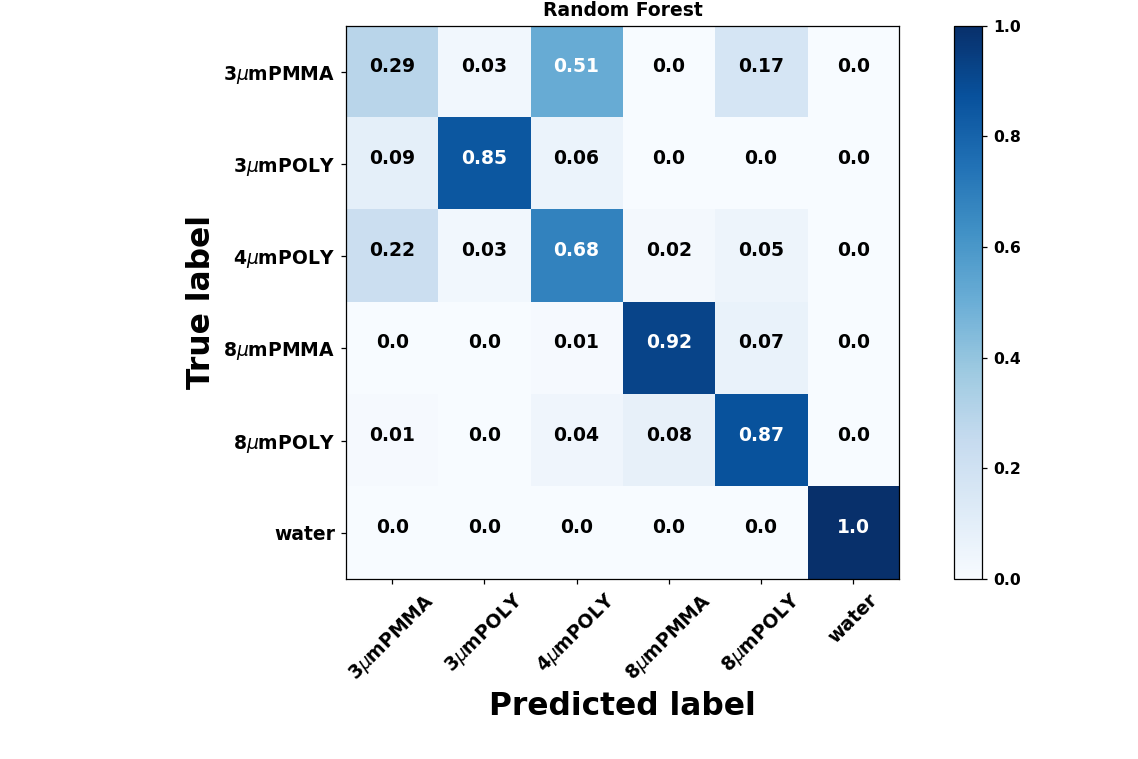

Confusion matrix, without normalization
KNeighborsClassifier(n_neighbors=30)
Accuracy Train -> 0.9245833696972622	0.9458980044345898	0.9104212860310421
Accuracy Test -> 0.8007721215318885	0.96	0.6777777777777778


<IPython.core.display.Javascript object>


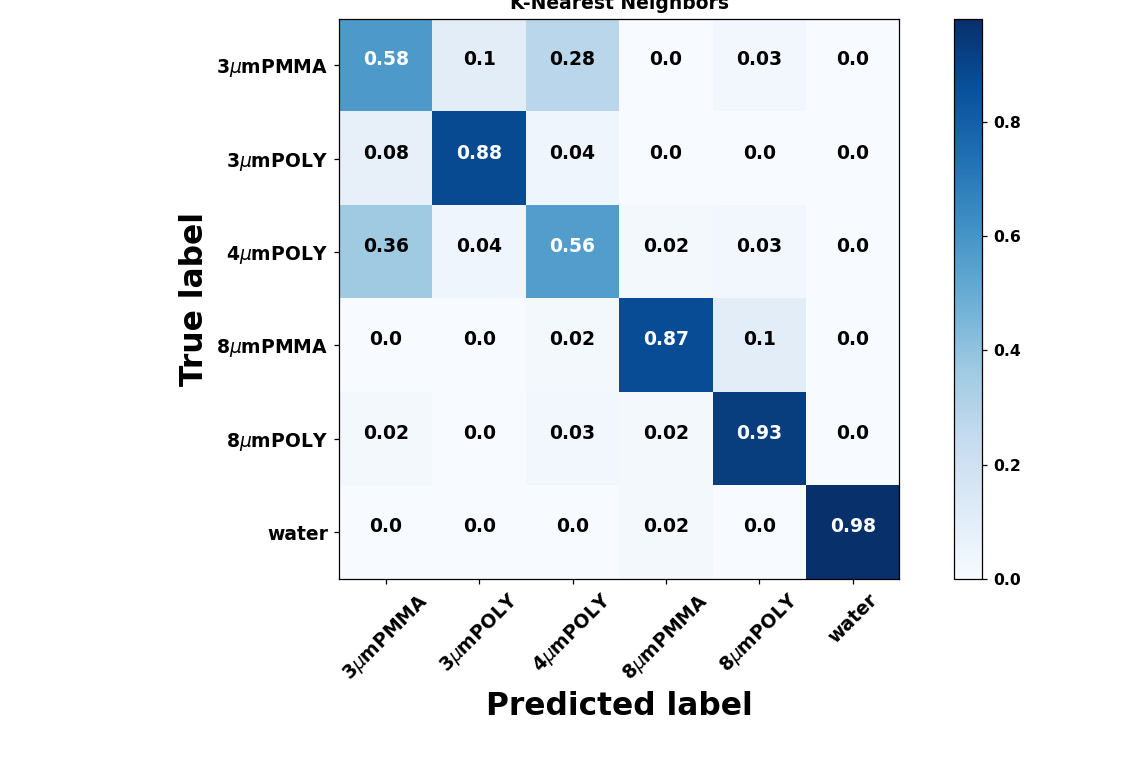

Confusion matrix, without normalization


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:05<00:00,  2.20s/it]


SVC(C=3, kernel='linear')
Accuracy Train -> 0.5975630225648229	0.628051486906347	0.5827050997782706
Accuracy Test -> 0.5837073882940493	0.6216814159292036	0.5033259423503326


<IPython.core.display.Javascript object>


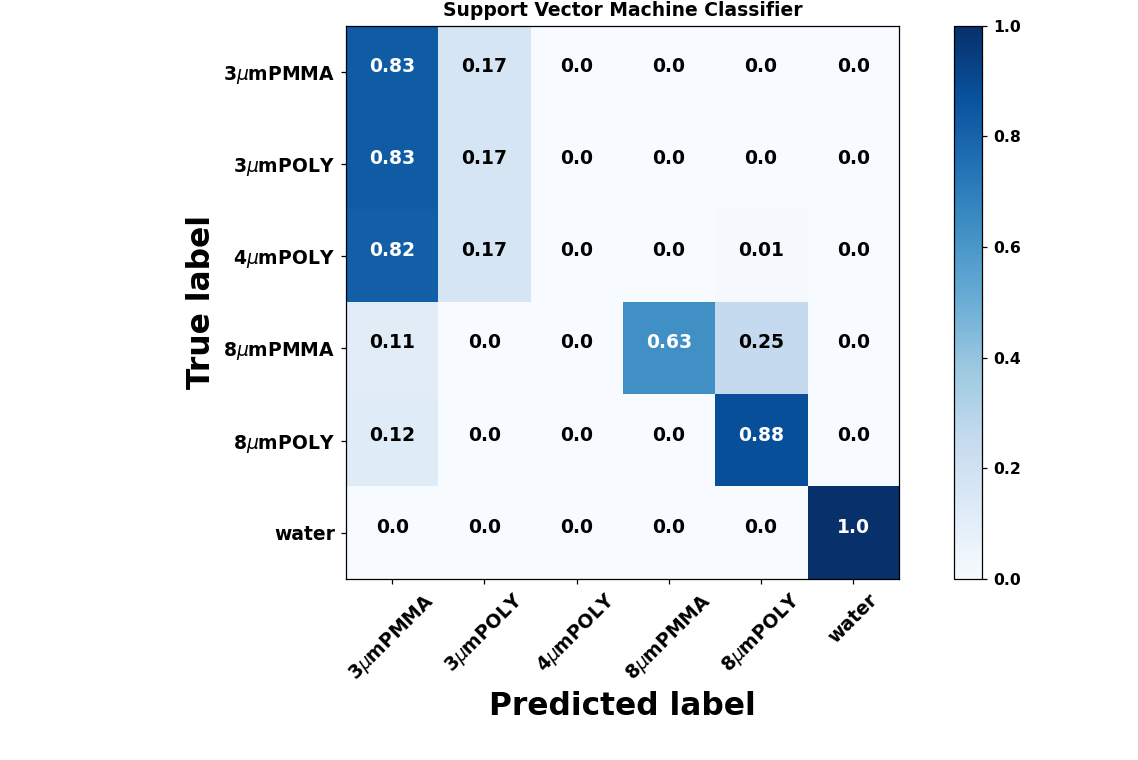

Confusion matrix, without normalization
LogisticRegression()
Accuracy Train -> 0.6476129007284256	0.6619343389529725	0.62982689747004
Accuracy Test -> 0.6350871729017639	0.672566371681416	0.6088888888888889


<IPython.core.display.Javascript object>


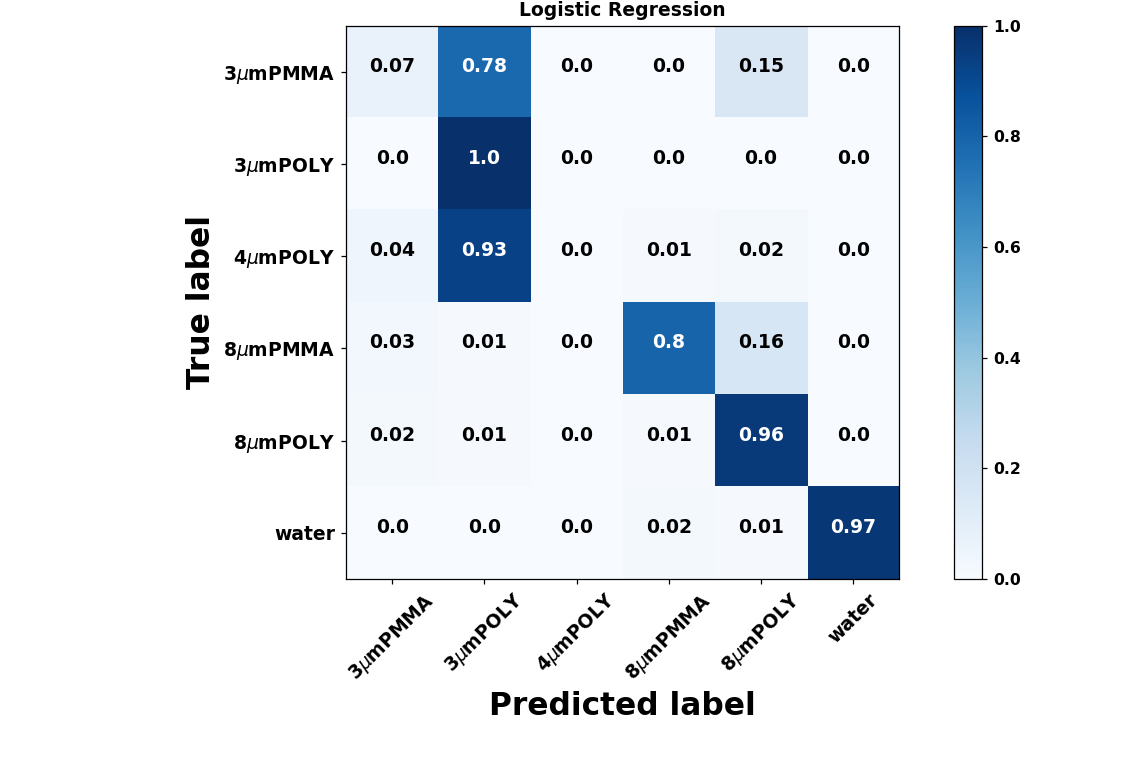

Confusion matrix, without normalization
MLPClassifier(activation='tanh')
Accuracy Train -> 0.7216232763350368	0.7955654101995565	0.6682926829268293
Accuracy Test -> 0.7126951978959318	0.8141592920353983	0.6


<IPython.core.display.Javascript object>


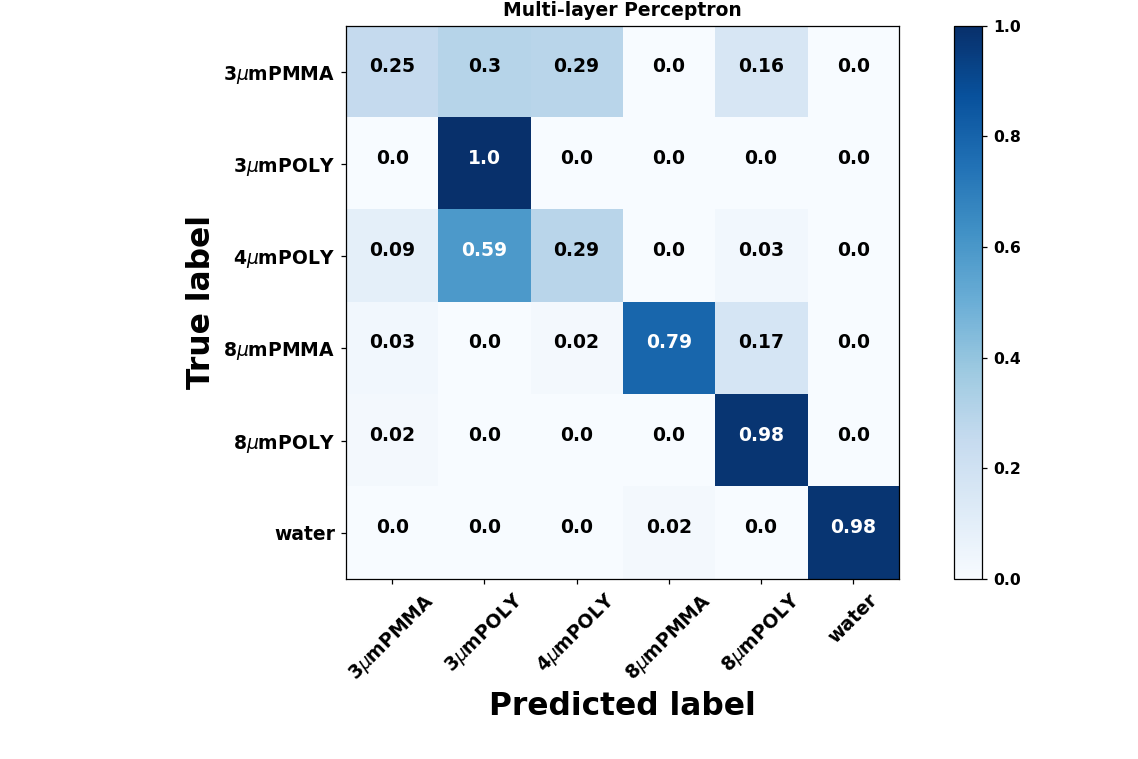

Confusion matrix, without normalization


In [23]:
%matplotlib notebook

unique_targets1=[]
for i in range(0,len(unique_targets)):
    unique_targets1.append(r''+unique_targets[i].replace('um','$\mu$m'))

models_labels=['Random Forest', 
                       'K-Nearest Neighbors',
                       'Support Vector Machine Classifier',
                       'Logistic Regression',
                       'Multi-layer Perceptron']
    
    
    
for i in range(0,len(models_to_test)):
    print(models_to_test[i])
    print("Accuracy Train -> "+ str(mean(model_list_score_train[i])), end = '\t')
    print(str(max(model_list_score_train[i])), end = '\t')
    print(str(min(model_list_score_train[i])), end = '\n')
    
    print("Accuracy Test -> "+ str(mean(model_list_score_test[i])), end = '\t')
    print(str(max(model_list_score_test[i])), end = '\t')
    print(str(min(model_list_score_test[i])), end = '\n')
    
    
    conf_mat_pred = model_list_conf_test[i]
    #metrics.ConfusionMatrixDisplay(np.round(conf_mat_pred,2),display_labels=unique_targets1).plot(cmap=cm.Blues)
    
    plot_confusion_matrix(np.round(conf_mat_pred,2),unique_targets1)

    ax=gca()
    ax.set_title(models_labels[i])
    savefig('images//All//'+models_labels[i], bbox_inches='tight',dpi=300)
        